In [58]:
import math
import numpy as np
import matplotlib.pyplot as plt
import random
%matplotlib inline

In [59]:
import math

class Value:
    def __init__(self, data, children=(), op=''):
        self.data = data # float
        self.children = children
        self.op = op
        self.grad = 0.0
        self._backward = lambda: None
        self.ValueId = id(self)

    def __repr__(self):
        return f"Value(data: {self.data})"

    def __add__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data + other.data, (self, other), '+')

        def _backward():
            self.grad += 1.0 * out.grad
            other.grad += 1.0 * out.grad
        out._backward = _backward

        return out
    
    def __radd__(self, other):
        return self + other


    def __neg__(self):
        return self * -1

    def __sub__(self, other):
        return self + (-other)

    def __rsub__(self, other):
        return other + (-self)


    def __mul__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data * other.data, (self, other), '*')

        def _backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad

        out._backward = _backward
        return out

    def __rmul__(self, other):
        return self * other

    def __pow__(self, other: int | float):
        assert isinstance(other, (float, int)), "Just 'float' and 'int' supported for now!"
        out = Value(self.data ** other, (self, ), '^')

        def _backward():
            self.grad += other * (self.data**(other-1)) * out.grad
        out._backward = _backward
        return out

    def __truediv__(self, other):
        return self * (other**-1)

    def exp(self):
        x = self.data
        out = Value(math.exp(x), (self, ), 'exp')

        def _backward():
            self.grad += out.data * out.grad

        out._backward = _backward
        return out

    def tanh(self):
        x = self.data
        exp2x = math.exp(2*x)
        t = (exp2x - 1) / (exp2x + 1)
        out = Value(t, (self,), 'tanh')

        def _backward():
            self.grad += (1 - t**2) * out.grad

        out._backward = _backward
        return out

    def backward(self):
        self.grad = 1.0  # Start gradient from output node
        topo = []
        visited = set()

        def build_topo(node: Value):
            if node not in visited:
                visited.add(node)
                for child in node.children:
                    build_topo(child)
                topo.append(node)

        build_topo(self)
        for node in reversed(topo):
            node._backward()

In [60]:
from graphviz import Digraph
import graphviz
print(graphviz.__version__)

def draw_graph(root, dispdata=True):
    dot = Digraph(format="svg", graph_attr={"rankdir": "LR", "bgcolor": "lightgray"})  # Set background color

    nodes, edges = set(), set()

    def build_graph(v, dispdata):
        if v not in nodes:
            nodes.add(v)

            # Create a node for the value with white text on a blue background
            dot.node(str(id(v)), f"{round(v.data, 5) if dispdata else round(v.grad, 5)}", 
                     shape="record", style="rounded,filled", fillcolor="lightblue", fontcolor="black")

            # Create a separate operation node with shape="none", small font, and minimal size
            if v.op:
                op_node_id = f"op_{id(v)}"
                dot.node(op_node_id, v.op, shape="none", fontsize="20", width="0.1", height="0.1", fontcolor="black")
                dot.edge(op_node_id, str(id(v)))  # Connect op node to value node

            for child in v.children:
                edges.add((child, v))
                build_graph(child, dispdata)

    build_graph(root, dispdata)

    for n1, n2 in edges:
        dot.edge(str(id(n1)), f"op_{id(n2)}")  # Connect value nodes to operation nodes

    return dot


0.20.3


In [61]:
class Neuron:
    def __init__(self, wNumber):
        self.w = [Value(random.uniform(-1, 1)) for i in range(wNumber)]
        self.b = Value(random.uniform(-1, 1))

    def __call__(self, x):                                         # Forward pass on the call operator.
        # w*x + b
        act = sum([wi*xi for wi, xi in zip(self.w, x)], self.b)
        return act.tanh()


In [62]:
class Layer:
    def __init__(self, nin, nout):
        self.neurons = [Neuron(nin) for _ in range(nout)]

    def __call__(self, x):
        outs = [n(x) for n in self.neurons]
        return outs

In [63]:
class MLP:
    def __init__(self, nin, nout):
        size = [nin] + nout
        self.layers = [Layer(size[i], size[i+1]) for i in range(len(nout))]

    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        return x

In [64]:
x = [2.0, 3.0, -1.0]
n = MLP(3, [4, 3, 3, 1])
v = n(x)

for ni in v:
    ni.backward()

In [ ]:
draw_graph(ni[0])

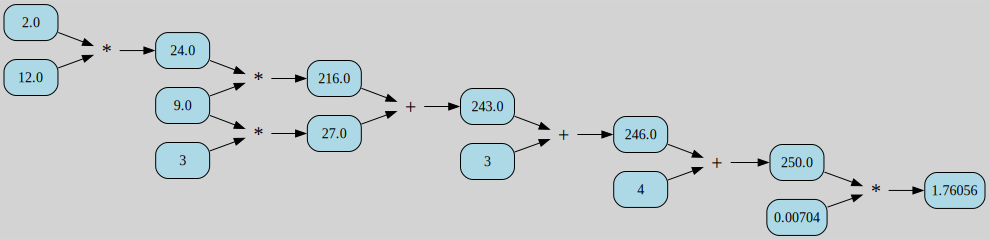

In [69]:
a = Value(1.0 + 1)
b = Value(12.0)
c = Value(9.0)

x1 = a*b*c + 3*c + 3
x2 = (x1 + 4) / 142.0

x2.backward()

draw_graph(x2, True)